In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import load

plt.style.use('seaborn')

## Stare dane i model

In [179]:
forest = load('../PD1/forest.joblib')
data = pd.read_pickle('../PD1/processed_data.pkl')

In [180]:
data = data.iloc[:,:-1]
data.head()

,InternetAccessFrq,PartnerAge,FirstMetPartnerYr,InternetDating,InterviewDuration
0,2,26.0,2017.0,1,9
1,2,52.0,1983.0,0,11
2,2,45.0,2006.0,0,7
3,2,26.0,2012.0,0,5
4,2,59.0,1983.0,0,13


In [298]:
class Explain:
    def _make_feature_spaces(self, df : pd.DataFrame, cols: list):
        return {x : np.sort(df[x].unique()) for x in cols}

    def _make_cp_space(self, idx: int, x: np.ndarray, space: np.ndarray):
        tmp = []
        for v in space:
            tmp_x = x.copy()
            tmp_x[idx] = v
            tmp.append(tmp_x)
        return np.array(tmp)

    def partialdp(self, model, df: pd.DataFrame, n: int =100,
                 cols: list = [],  all: bool = False, size=(10,20)):
        """
        Takes model, dataframe, number od samples and list of column names /
        feature names for which pdp will be plotted. 
        If all then pdps are plotted for every feature
        """
        # Sanity...
        msg = 'Model has no predict method.'
        assert hasattr(model, 'predict_proba'), msg
        
        # Set default value to first column or take all columns
        if not all and len(cols) == 0:
            cols = [df.columns[0]]
        if all:
            cols = list(df.columns)
            
        smpl = df.sample(n)
        space = self._make_feature_spaces(df, cols)
        plot_data = dict()
        for i, c in enumerate(cols):
            plot_data[c] = [self._make_cp_space(list(df.columns).index(c), x, space.get(c)) for x in smpl.values]
        
        fig = plt.figure(1, figsize=size)
        fig.suptitle('Partial Dependency Plots', fontsize=18)
        n = np.ceil(len(cols)/3)
        m = len(list(plot_data))
        
        for i, (t, v) in enumerate(plot_data.items()):
            if m > 1:
                plt.subplot(n, 3, i+1)
            plt.title(t)
            tmp = []
            for s in v:
                y = model.predict_proba(s)[:,1]
                x = [el[list(df.columns).index(t)] for el in s]
                plt.plot(x, y, color='black', alpha=0.2)
                tmp.append(y)
                
            plt.plot(x, np.mean(tmp, axis=0), color='orange', linewidth=5, alpha=0.9)    
        plt.show()

    def ceterisp(self, model, df: pd.DataFrame, x: np.ndarray, 
                 cols: list = [],  all: bool = False, size=(10,20)):

        # Sanity...
        if not isinstance(x, np.ndarray):
            x = np.array(x)
            
        assert x.size == df.shape[1], 'Sample and df sizes differ'
        msg = 'Model has no predict method.'
        assert hasattr(model, 'predict_proba'), msg
        
        # Set default value to first column or take all columns
        if not all and len(cols) == 0:
            cols = [df.columns[0]]
        if all:
            cols = list(df.columns)
        
        # Obtain spaces for each feature in cols
        space = self._make_feature_spaces(df, cols)
        
        # Create new samples based on x
        plot_data = dict()
        for i, c in enumerate(df.columns):
            if c in cols:
                plot_data[c] = self._make_cp_space(i, x, space.get(c))
        
        # Make plots
        fig = plt.figure(1, figsize=size)
        fig.suptitle('Ceteris Paribus Plots', fontsize=18)
        n = np.ceil(len(cols)/3)
        m = len(list(plot_data))
        for i, (t, v) in enumerate(plot_data.items()):
            if m > 1:
                plt.subplot(n, 3, i+1)
            plt.title(t)
            
            idx = list(df.columns).index(t)
            xs = [el[idx] for el in v]
            plt.plot(xs, model.predict_proba(v)[:,1])
            # Make dot
            y = model.predict_proba([x])[:,1]
            xp = x[idx]
            plt.scatter(xp, y, color='red')
            
        plt.show()
        
    def ale(self, model, data: pd.DataFrame, col: str, bins = 4,  size=(15, 6)):
        df = data.copy()
        df['bins'] = pd.cut(df[col], bins)
        
        points =[]
        for b in df.bins.unique():
            tmp = df[df.bins == b]
            
            up = tmp.copy()
            up[col] = up[col].apply(lambda x: float(b.right))
            
            down = tmp.copy()
            down[col] = down[col].apply(lambda x: float(b.left))
            
            up = model.predict_proba(up.iloc[:,:-1])[:,1]
            down = model.predict_proba(down.iloc[:,:-1])[:,1]
            
            points.append((float((b.right + b.left) / 2), np.mean(up - down)))
            
        points.sort(key = lambda x: x[0])
        xs = [p[0] for p in points]
        ys = [p[1] for p in points]
        
        fig = plt.figure(figsize=size)
        fig.suptitle('Acumulated Local Effects', fontsize=18)
        
        plt.title(col)
        plt.plot(xs, np.cumsum(ys))
        
        return xs, ys
        
        
        
        
ex = Explain()    

## Losowa próbka do CP

In [249]:
sample = data.sample(1)
sample

,InternetAccessFrq,PartnerAge,FirstMetPartnerYr,InternetDating,InterviewDuration
1685,2,48.0,2000.0,0,10


### Rok w którym partnerzy sie poznali

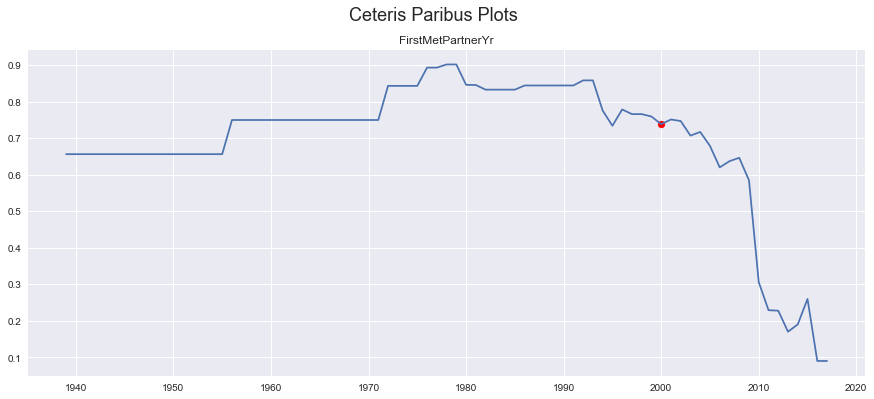

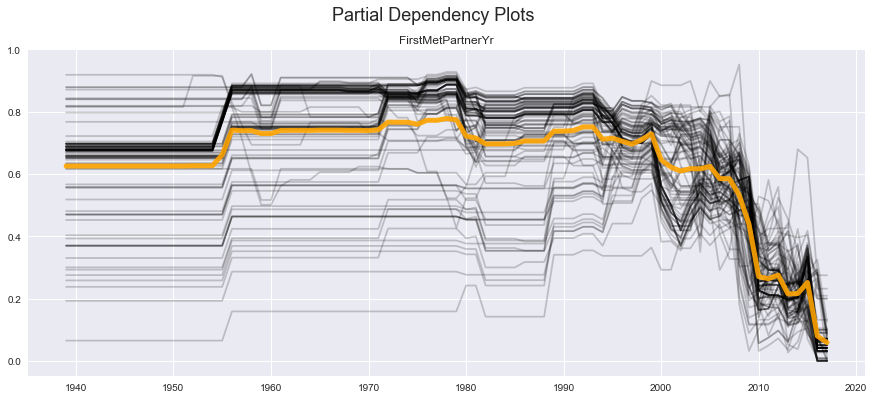

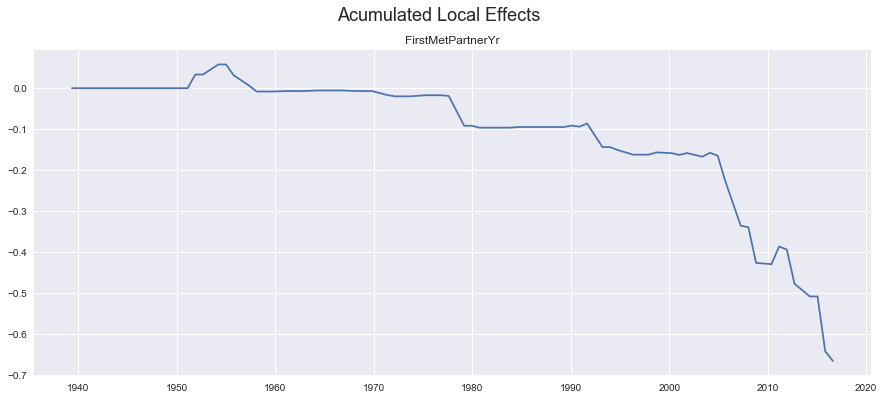

In [294]:
feature = 'FirstMetPartnerYr'
dat = ex.ceterisp(forest, data, sample.values[0], cols=[feature], size=(15, 6))
dat = ex.partialdp(forest, data, cols=[feature], size=(15, 6))
xs, ys = ex.ale(forest, data, feature, bins=100)

Profile PDP i ALE są zgodne, co więcej zgadzają się z intuicją. Sugerują bowiem, że im dłużej partnerzy się znają tym większa szansa, że są w związku małżeńskim. Można również pokusić się o sugestię, że pary które poznały się przed 2000 rokiem chętniej zwierały związki małżeńskie.

## Wiek partnera

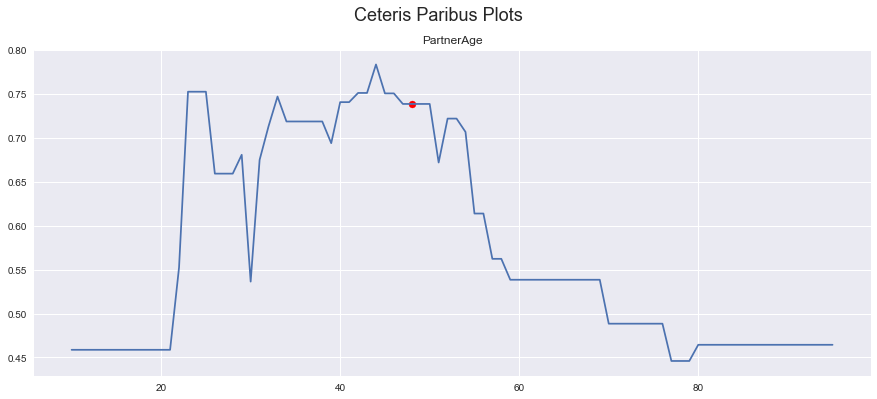

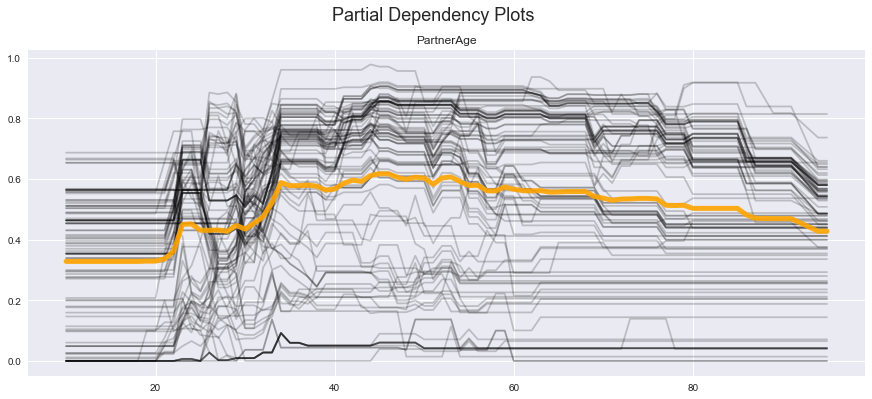

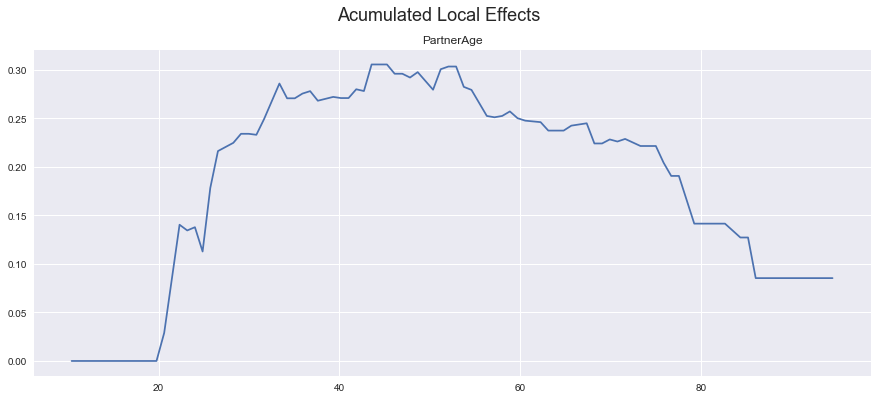

In [295]:
feature = 'PartnerAge'
dat = ex.ceterisp(forest, data, sample.values[0], cols=[feature], size=(15, 6))
dat = ex.partialdp(forest, data, cols=[feature], size=(15, 6))
xs, ys = ex.ale(forest, data, feature, bins=100)

W przypadku wieku partnera również widzimy zgodność. Szansa wejścia w związek małżeśki wzrasta w przedziale od około 20 do 50 roku życia. ALE sugeruje jednak, że wiek partner po 50 ma większe znaczenie niż mogłoby to wynikać z PDP.